## Building chatbot with multiple Tools using Langgraph

create a chatbot  with tools capabilities form arxiv, wikipeeia search and other tools

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper



In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")


In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [5]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("Hi, what is machin learning?")

'Page: Haitian Creole\nSummary: Haitian Creole (; French: Créole haïtien [kʁeɔl ajisjɛ̃] ; Haitian Creole: kreyòl ayisyen, [kɣejɔl ajisjɛ̃]), or simply Creole (Haitian Creole: kreyòl), is a Niger–Congo and French-based creole language that is spoken by over 13 million Haitian people worldwide. It is one of the two official languages of Haiti (the other being French), where it is the native language of the vast majority of the population. It is also the most widely spoken creole language in the wor'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")


In [8]:
## Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

/tmp/ipykernel_3737/1396243078.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [9]:
tavily.invoke("Provide me recent AI news")

[{'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': 'Source: China Daily\n\n### Disney Integrates Generative AI into Core Operating Model\n\nDate: December 24, 2025\n\nSummary: The Walt Disney Company has officially begun embedding generative AI across its entire operating structure, moving beyond experimental projects to fundamental business integration. The initiative aims to enhance efficiency in content creation, post-production, and personalized guest experiences within its theme parks. By centralizing AI development, Disney hopes to streamline creative workflows and leverage its massive library of intellectual property to train proprietary models while maintaining strict control over brand integrity and copyright.\n\nSource: AI News ↗\n\n### AI Bubble Hits Salesforce: Executives Acknowledge Trust Issues, Scale Back AI After Major Layoffs [...] Date: December 26, 2025\n\nS

In [10]:
## combine all tools in a list

tools=[arxiv,wiki,tavily]


In [11]:
from langchain_groq import ChatGroq
llm= ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

/home/maniram/workspace/python/langchain-projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [12]:
from pprint import pprint
from langchain_core.messages import HumanMessage
response=llm_with_tools.invoke([HumanMessage(content="What is the recen AI news?")])
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'awj509jfg',
  'type': 'tool_call'}]

In [17]:
### State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

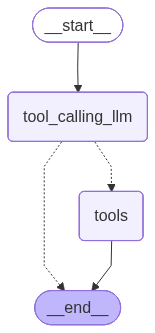

In [22]:
### Entire Chatbot using LangGraph

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node definition
def tool_calling_llm(state:State):
    return { "messages":[llm_with_tools.invoke(state["messages"])] }

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (1cherj7d7)
 Call ID: 1cherj7d7
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [25]:
messages=graph.invoke({"messages":HumanMessage(content="provide me top 10 recent AI news in January 2026")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

provide me top 10 recent AI news in January 2026
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (10655kkmx)
 Call ID: 10655kkmx
  Args:
    query: top 10 AI news in January 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top AI News for January 2026: Breakthroughs, Launches & Trends ...", "url": "https://www.aiapps.com/blog/ai-news-january-2026-breakthroughs-launches-trends/", "content": "## Major AI Developments in January 2026\n\n### Falcon-H1R: 7B Reasoning Model\n\nIn January 2026, the Technology Innovation Institute (TII) unveiled Falcon-H1R 7B, a compact AI model that delivers performance comparable to systems up to seven times its size. Built on a Transformer–Mamba hybrid architecture, Falcon-H1R strikes a balance between speed and memory eff